# Import Libraries

In [22]:
#import urllib2
from io import StringIO
import os
import xmltodict
import pandas as pd
from datetime import datetime 
import statsmodels.api as sm

from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import sys
import requests
import pymannkendall as mk
import glob

import matplotlib

import scipy

import geopandas as gpd

from bs4 import BeautifulSoup

import platform
import os

import matplotlib as mpl

from IPython.display import Math,display

from scipy.optimize import curve_fit
import pymannkendall as mk
from pylab import rcParams
%matplotlib inline
matplotlib.rc_file_defaults()
rcParams['figure.figsize'] = 15, 10

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
#print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 10
Python Version 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:10:34) [MSC v.1916 64 bit (AMD64)]
Pandas Version 1.3.1
Numpy Version 1.21.1
Matplotlib Version 3.4.2
Scipy Version 1.6.3
pygis39


# Read in Hypsometric Data

Hypsometric Curves are provided with all modern dam designs. Dam plans can be downloaded from the [Water Rights Dam Safty Website](https://maps.waterrights.utah.gov/EsriMap/map.asp?layersToAdd=Dams). You have to be on a state network to access them.

I digitized the curves in from the plans for the dams in the study area using ArcGIS Pro and a Planar projection that uses feet.

In [3]:
hypsometric_data = gpd.read_file("G:/Shared drives/UGS_Groundwater/Projects/Bryce/GIS/Bryce/Bryce.gdb", 
                                 driver='FileGDB', layer='damcurves_points')
hypsometric_data

,linetype,dam,InLine_FID,SimLnFlag,MaxSimpTol,MinSimpTol,ORIG_FID,x,y,geometry
0,area,tropic new,1,0,0.1,0.1,1,0.308608,7809.988071,POINT Z (0.309 7809.988 0.000)
1,area,tropic new,1,0,0.1,0.1,1,0.755786,7811.236100,POINT Z (0.756 7811.236 0.000)
2,area,tropic new,1,0,0.1,0.1,1,1.226257,7812.475271,POINT Z (1.226 7812.475 0.000)
3,area,tropic new,1,0,0.1,0.1,1,1.720351,7813.705583,POINT Z (1.720 7813.706 0.000)
4,area,tropic new,1,0,0.1,0.1,1,2.237410,7814.926053,POINT Z (2.237 7814.926 0.000)
...,...,...,...,...,...,...,...,...,...,...
549,outlet,None,11,0,0.1,0.1,11,92.219186,7997.868929,POINT Z (92.219 7997.869 0.000)
550,outlet,None,11,0,0.1,0.1,11,92.598122,7998.188482,POINT Z (92.598 7998.188 0.000)
551,outlet,None,11,0,0.1,0.1,11,92.976074,7998.509348,POINT Z (92.976 7998.509 0.000)
552,outlet,None,11,0,0.1,0.1,11,93.352713,7998.831526,POINT Z (93.353 7998.832 0.000)


## Tropic Reservoir Curves

### Volume in Lake vs Lake Elevation Relationship - Tropic

C:\Users\PAULIN~1\AppData\Local\Temp/ipykernel_13004/3262229987.py:12: RuntimeWarning: invalid value encountered in sqrt
  sterr = np.sqrt(np.diag(pcov))


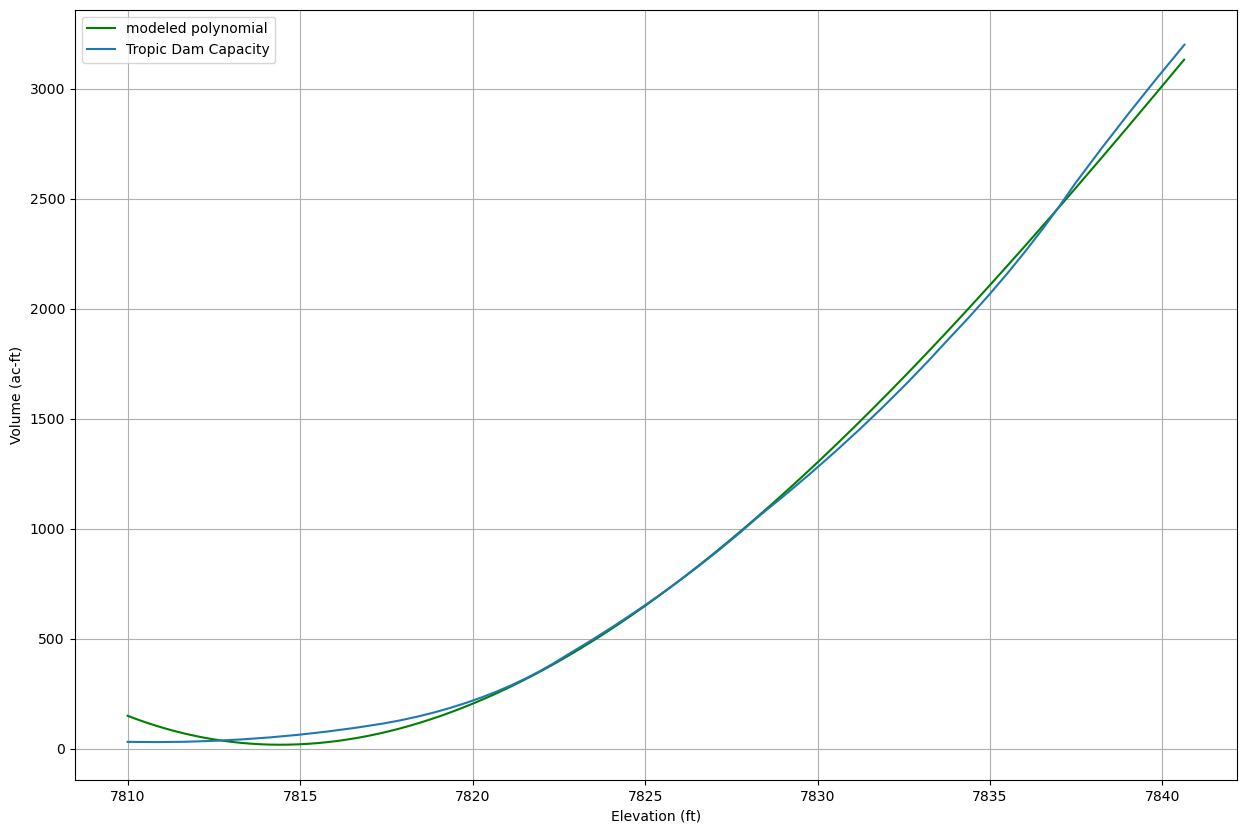

In [162]:
hyps_data = hypsometric_data[(hypsometric_data['dam']=="tropic new")&(hypsometric_data['linetype']=="capacity")][['x','y']]
hyps_old = hypsometric_data[(hypsometric_data['dam']=="tropic old")&(hypsometric_data['linetype']=="capacity")][['x','y']]

# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

x = hyps_data['y']
yn = hyps_data['x']*100

vpopt, pcov = curve_fit(objective, x, yn, maxfev = 40000)
sterr = np.sqrt(np.diag(pcov))
a, b, c, d, e, f = vpopt

xb = np.arange(np.min(x),np.max(x),0.01)

# calculate the output for the range
yb = objective(xb, a, b, c, d, e, f)

plt.plot(xb, yb, label= "modeled polynomial",color='green')
plt.plot(hyps_data['y'], hyps_data['x']*100, label='Tropic Dam Capacity')
plt.xlabel('Elevation (ft)')
plt.ylabel('Volume (ac-ft)')
plt.grid()
#plt.ylim(0,3500)
plt.legend()




### Area of Open Water vs Lake Elevation Relationship - Tropic

(1.715 * x) + (0.564 * x^2) + (-1.164e-02 * x^3) + (2.217e-06 * x^4) + (-1.131e-10 * x^5) + 5.471e+08


C:\Users\PAULIN~1\AppData\Local\Temp/ipykernel_13004/3541634429.py:11: RuntimeWarning: invalid value encountered in sqrt
  sterr = np.sqrt(np.diag(pcov))


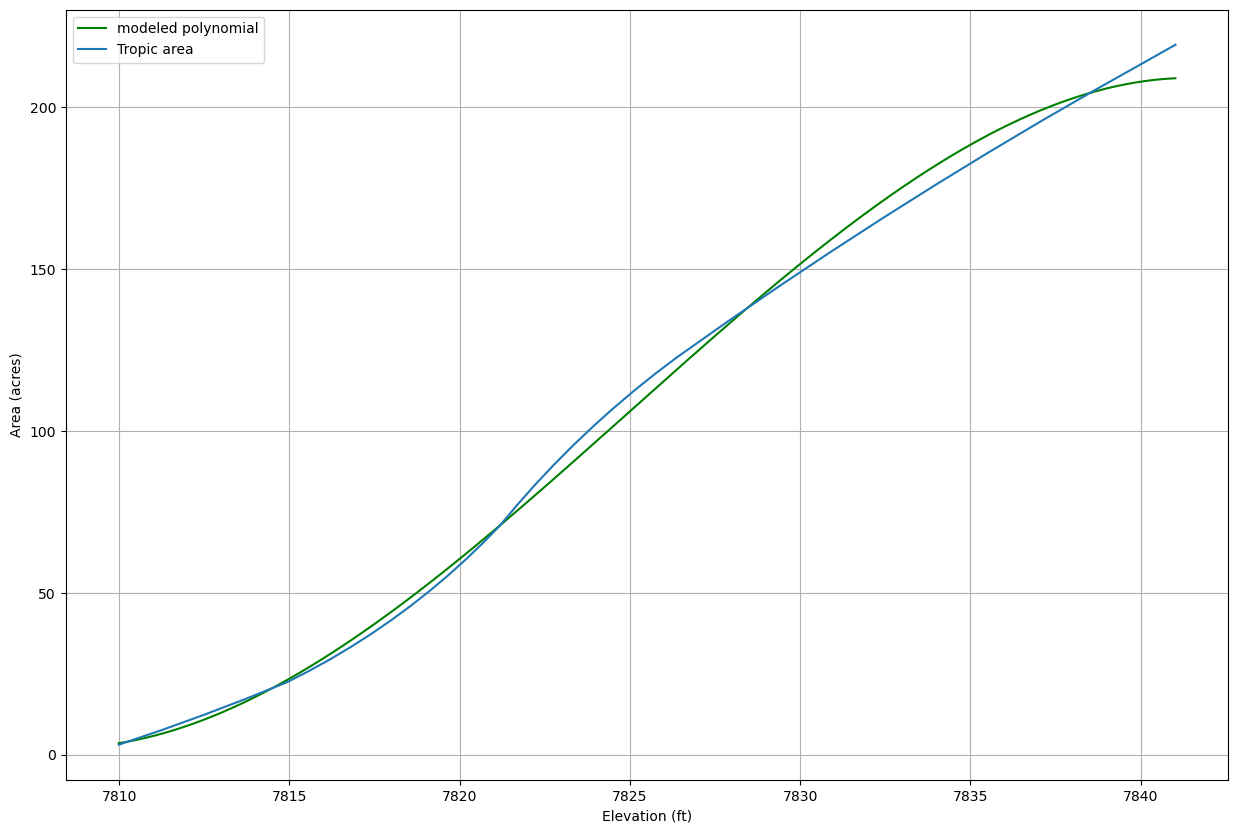

In [186]:
hyps_data = hypsometric_data[(hypsometric_data['dam']=="tropic new")&(hypsometric_data['linetype']=="area")][['x','y']]

# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

x = hyps_data['y']
yn = hyps_data['x']*10

vpopt, pcov = curve_fit(objective, x, yn, maxfev = 40000)
sterr = np.sqrt(np.diag(pcov))
a, b, c, d, e, f = vpopt

xb = np.arange(np.min(x),np.max(x),0.01)

# calculate the output for the range
yb = objective(xb, a, b, c, d, e, f)

plt.plot(xb, yb, label= "modeled polynomial",color='green')
plt.plot(hyps_data['y'], hyps_data['x']*10, label='Tropic area')
plt.xlabel('Elevation (ft)')
plt.ylabel('Area (acres)')
plt.grid()
#plt.ylim(0,3500)
plt.legend()
print(f"({a:0.3f} * x) + ({b:0.3f} * x^2) + ({c:0.3e} * x^3) + ({d:0.3e} * x^4) + ({e:0.3e} * x^5) + {f:0.3e}")

### Discharge Outflow vs. Reservoir Level Elevation

(0.961 * x) + (1.690 * x^2) + (4.169e-01 * x^3) + (-7.995e-05 * x^4) + (4.086e-09 * x^5) + -2.002e+10


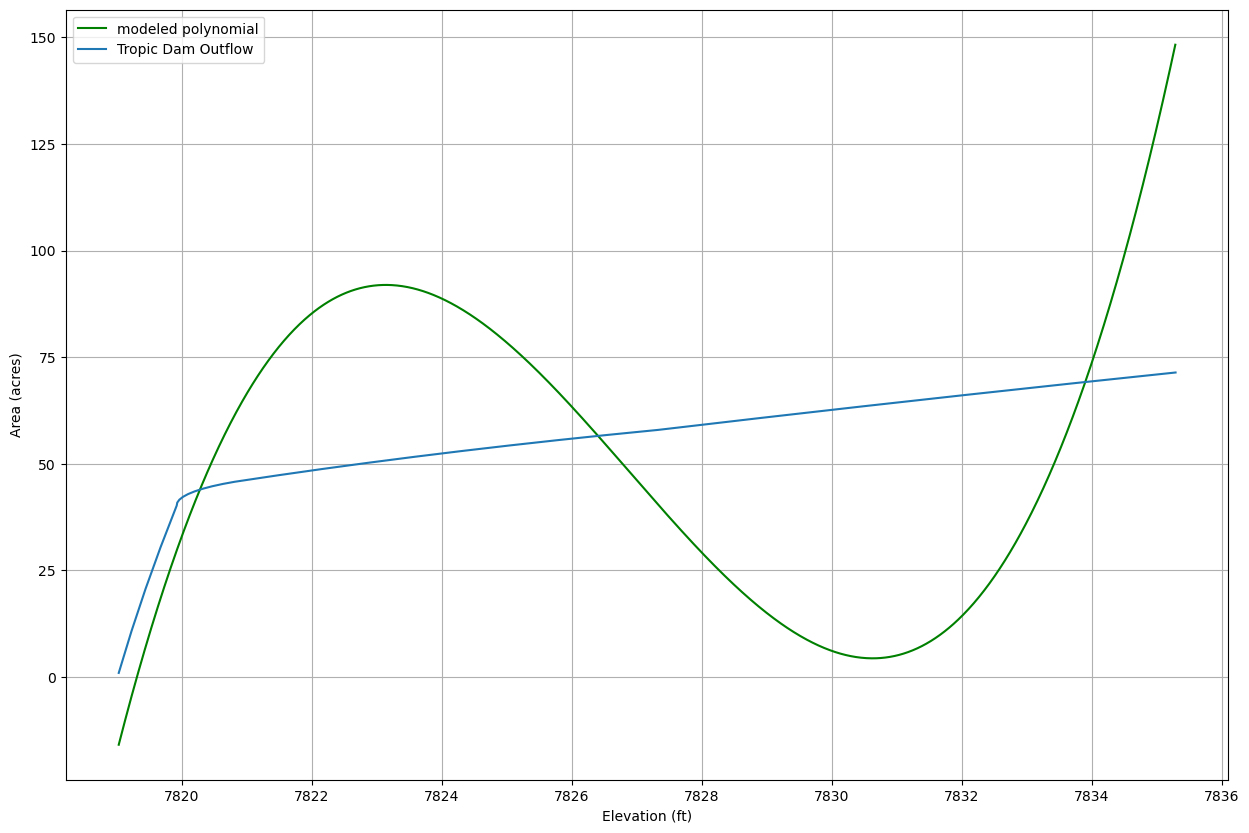

In [188]:
hyps_data = hypsometric_data[(hypsometric_data['dam']=='tropic new')&(hypsometric_data['linetype']=="outlet")][['x','y']]

# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

x = hyps_data['y']
yn = hyps_data['x']*2.5

vpopt, pcov = curve_fit(objective, x, yn, maxfev = 40000)
sterr = np.sqrt(np.diag(pcov))
a, b, c, d, e, f = vpopt

xb = np.arange(np.min(x),np.max(x),0.01)

# calculate the output for the range
yb = objective(xb, a, b, c, d, e, f)

plt.plot(xb, yb, label= "modeled polynomial",color='green')
plt.plot(hyps_data['y'], hyps_data['x']*2.5, label='Tropic Dam Outflow')
plt.xlabel('Elevation (ft)')
plt.ylabel('Area (acres)')
plt.grid()
#plt.ylim(0,3500)
plt.legend()
print(f"({a:0.3f} * x) + ({b:0.3f} * x^2) + ({c:0.3e} * x^3) + ({d:0.3e} * x^4) + ({e:0.3e} * x^5) + {f:0.3e}")

In [187]:
10/4

2.5

## Pine Lake Reservoir Curves

### Volume in Lake vs Lake Elevation Relationship

(17.173 * x) + (56.737 * x^2) + (-5.420e-03 * x^3) + (-3.290e-07 * x^4) + (3.939e-11 * x^5) + -7.995e+08


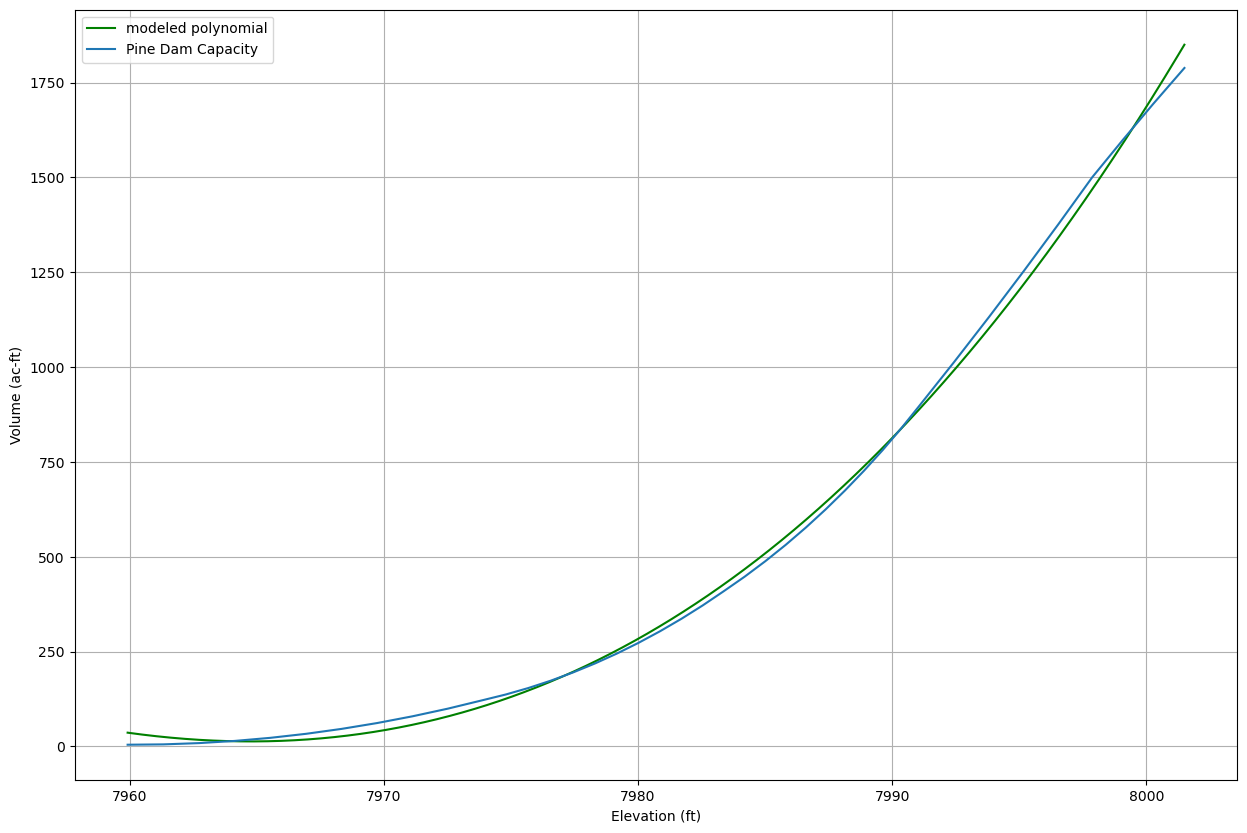

In [176]:
hyps_data = hypsometric_data[(hypsometric_data['dam']=="pine")&(hypsometric_data['linetype']=="capacity")][['x','y']]

# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

x = hyps_data['y']
yn = hyps_data['x']*100

vpopt, pcov = curve_fit(objective, x, yn, maxfev = 40000)
sterr = np.sqrt(np.diag(pcov))
a, b, c, d, e, f = vpopt

xb = np.arange(np.min(x),np.max(x),0.01)

# calculate the output for the range
yb = objective(xb, a, b, c, d, e, f)

plt.plot(xb, yb, label= "modeled polynomial",color='green')
plt.plot(hyps_data['y'], hyps_data['x']*100, label='Pine Dam Capacity')
plt.xlabel('Elevation (ft)')
plt.ylabel('Volume (ac-ft)')
plt.grid()
#plt.ylim(0,3500)
plt.legend()
print(f"({a:0.3f} * x) + ({b:0.3f} * x^2) + ({c:0.3e} * x^3) + ({d:0.3e} * x^4) + ({e:0.3e} * x^5) + {f:0.3e}")

### Area of Open Water vs Lake Elevation Relationship

(-0.111 * x) + (-7.352 * x^2) + (5.350e-04 * x^3) + (7.232e-08 * x^4) + (-6.503e-12 * x^5) + 1.135e+08


C:\Users\PAULIN~1\AppData\Local\Temp/ipykernel_13004/789420011.py:11: RuntimeWarning: invalid value encountered in sqrt
  sterr = np.sqrt(np.diag(pcov))


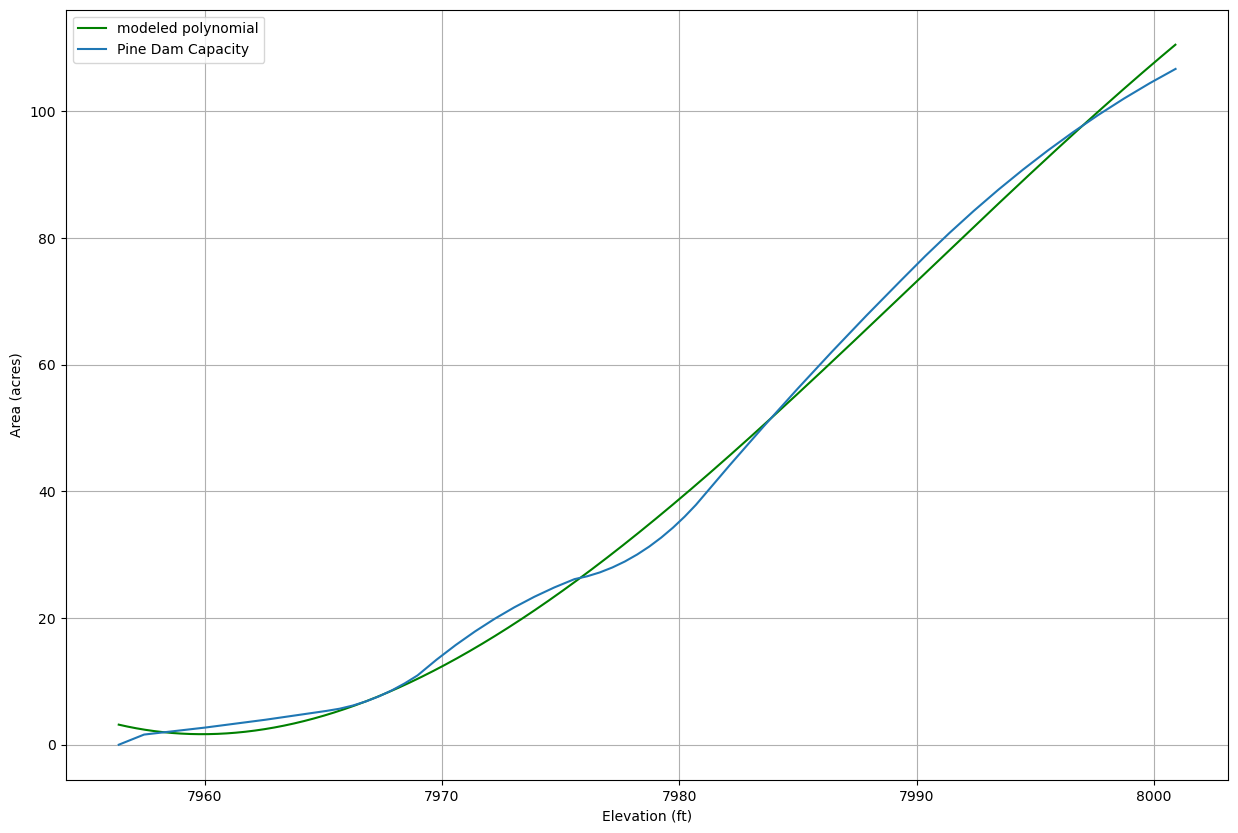

In [175]:
hyps_data = hypsometric_data[(hypsometric_data['dam']=="pine")&(hypsometric_data['linetype']=="area")][['x','y']]

# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

x = hyps_data['y']
yn = hyps_data['x']*7.5

vpopt, pcov = curve_fit(objective, x, yn, maxfev = 40000)
sterr = np.sqrt(np.diag(pcov))
a, b, c, d, e, f = vpopt

xb = np.arange(np.min(x),np.max(x),0.01)

# calculate the output for the range
yb = objective(xb, a, b, c, d, e, f)

plt.plot(xb, yb, label= "modeled polynomial",color='green')
plt.plot(hyps_data['y'], hyps_data['x']*7.5, label='Pine Dam Capacity')
plt.xlabel('Elevation (ft)')
plt.ylabel('Area (acres)')
plt.grid()
#plt.ylim(0,3500)
plt.legend()
print(f"({a:0.3f} * x) + ({b:0.3f} * x^2) + ({c:0.3e} * x^3) + ({d:0.3e} * x^4) + ({e:0.3e} * x^5) + {f:0.3e}")

### Discharge Outflow vs. Reservoir Level Elevation

(1.021 * x) + (2.695 * x^2) + (-2.394e-03 * x^3) + (3.874e-07 * x^4) + (-1.840e-11 * x^5) + 6.952e+07


C:\Users\PAULIN~1\AppData\Local\Temp/ipykernel_13004/2105497321.py:11: RuntimeWarning: invalid value encountered in sqrt
  sterr = np.sqrt(np.diag(pcov))


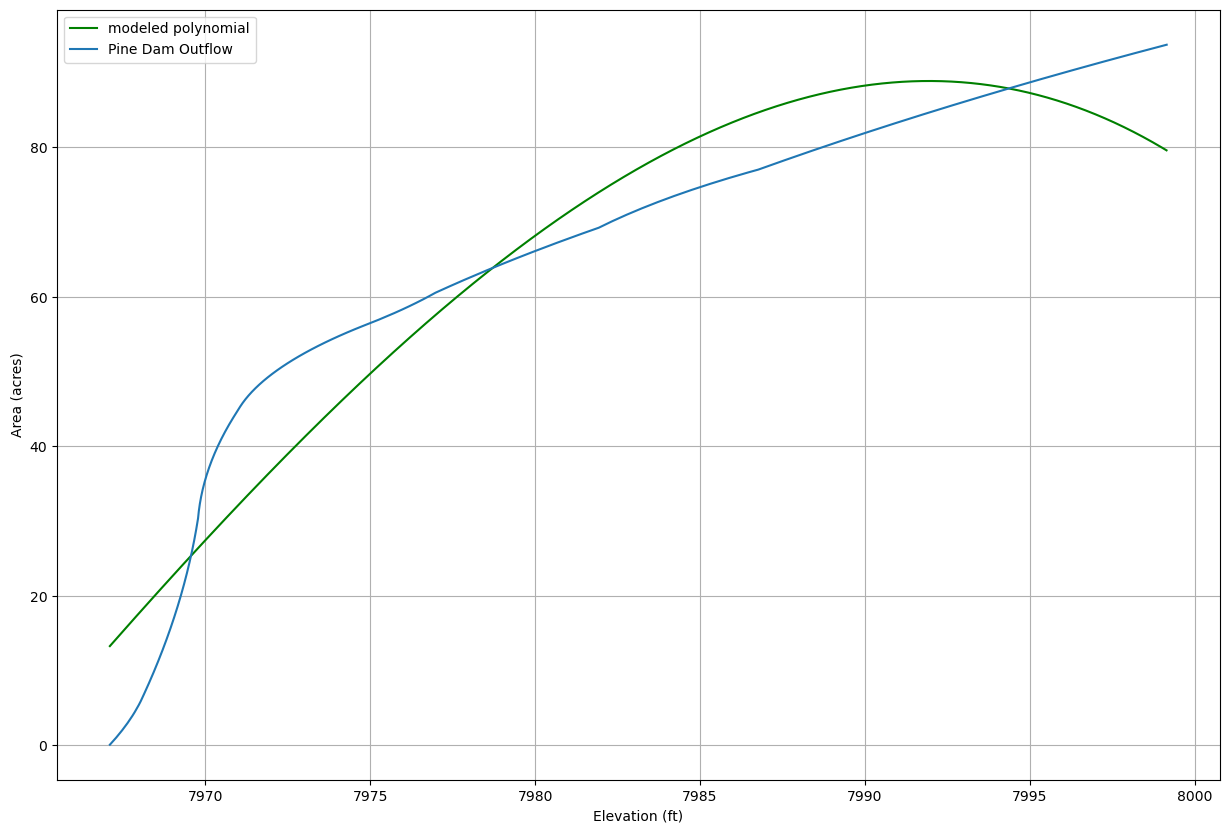

In [179]:
hyps_data = hypsometric_data[pd.isna(hypsometric_data['dam'])&(hypsometric_data['linetype']=="outlet")][['x','y']]

# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

x = hyps_data['y']
yn = hyps_data['x']

vpopt, pcov = curve_fit(objective, x, yn, maxfev = 40000)
sterr = np.sqrt(np.diag(pcov))
a, b, c, d, e, f = vpopt

xb = np.arange(np.min(x),np.max(x),0.01)

# calculate the output for the range
yb = objective(xb, a, b, c, d, e, f)

plt.plot(xb, yb, label= "modeled polynomial",color='green')
plt.plot(hyps_data['y'], hyps_data['x'], label='Pine Dam Outflow')
plt.xlabel('Elevation (ft)')
plt.ylabel('Area (acres)')
plt.grid()
#plt.ylim(0,3500)
plt.legend()
print(f"({a:0.3f} * x) + ({b:0.3f} * x^2) + ({c:0.3e} * x^3) + ({d:0.3e} * x^4) + ({e:0.3e} * x^5) + {f:0.3e}")

7.5

7.5

# Import Data From Dam Safty Website and Parse It

Dam operators regularly report data from dam piezometers, and also report dam flow and dam levels.

These data are pulled from an Excel Workbook that can pull data from the website using a programmed query.  Make sure to update the data in the workbook periodically to ensure we capture all of the data.

## Pine Lake

Links to Water Rights Data:<br>
[Pine Dam Information](https://www.waterrights.utah.gov/cgi-bin/damview.exe?Modinfo=Viewdam&DAM_NUMBER=UT00246)<br>
[Pine data site](https://www.waterrights.utah.gov/cgi-bin/damview.exe?Modinfo=ViewMonitorData&DAM_NUMBER=UT00246)


In [138]:
pine = pd.read_excel("G:/Shared drives/UGS_Groundwater/Projects/Bryce/Dams/Live_Dam_Data.xlsx","Pine Lake",
                     skiprows=[1],parse_dates=True,index_col=0)

In [156]:
pine.head()

,Res. Elev,p-1white,p-1orange,p-3white,p-3orange,p-8white,p-8orange,P10,P11,P12,...,D2,D3,D4,D5,p,p-2orange abandoned,p-4white Abandon,p-4orange Abandon,p-7white Abandon,p-7orange Abandon
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7975.200,7976.000,7975.920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-04,7992.00,7987.15,7984.35,7989.65,7985.65,7969.5,7965.35,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-09,7991.50,7986.10,7983.90,7989.10,7985.30,7968.3,7964.80,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-03,NaN,7986.40,7983.80,7990.40,7985.60,7969.9,7965.30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29,7991.75,7986.40,7984.10,7990.00,7985.80,7970.6,7965.90,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Reservoir Elevation (ft)')

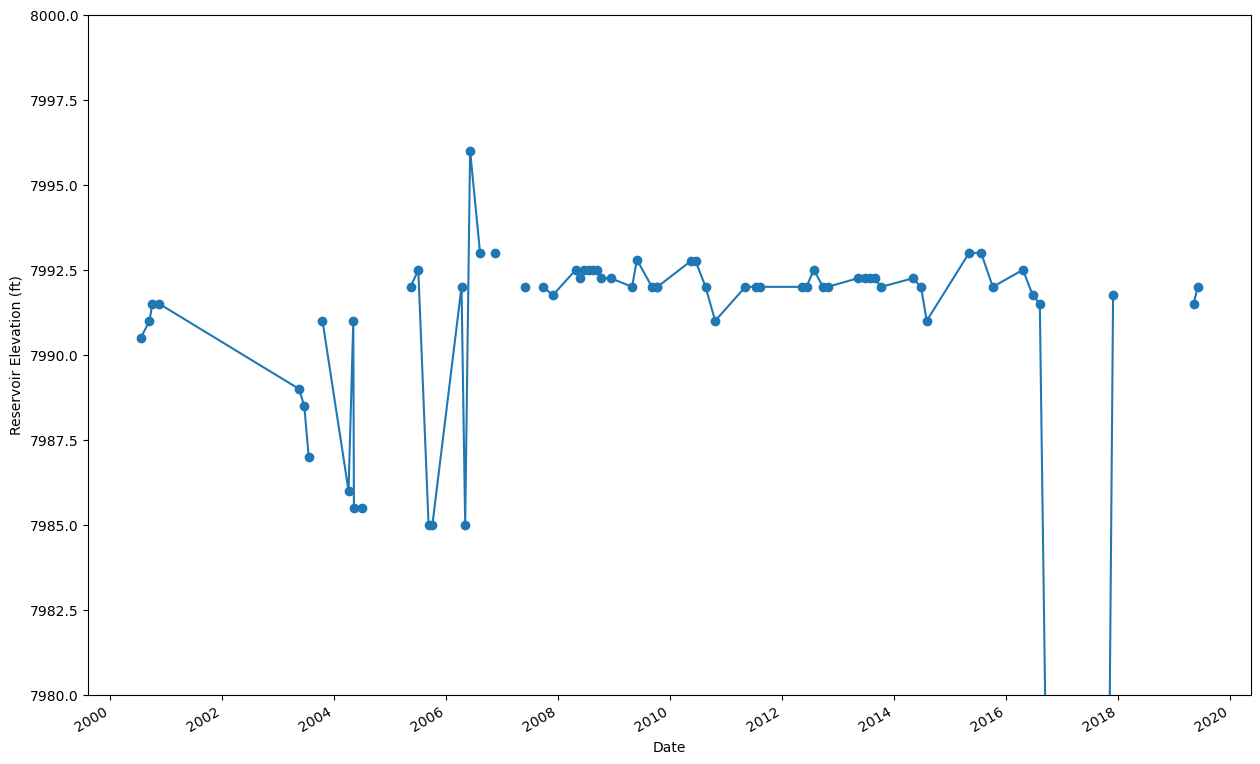

In [147]:
pine['Res. Elev'].plot(marker='o')
plt.ylim(7980,8000)
plt.ylabel('Reservoir Elevation (ft)')


## Tropic Reservoir

[Tropic Dam Information](https://www.waterrights.utah.gov/cgi-bin/damview.exe?Modinfo=Viewdam&DAM_NUMBER=UT00302)<br>
[Tropic Dam Data](https://www.waterrights.utah.gov/cgi-bin/damview.exe?Modinfo=ViewMonitorData&DAM_NUMBER=UT00302) 


In [149]:
tropic = pd.read_excel("G:/Shared drives/UGS_Groundwater/Projects/Bryce/Dams/Live_Dam_Data.xlsx",
                       "Tropic",skiprows=[1],index_col=0,parse_dates=True)

In [150]:
tropic.head()

,Reservoir Level,B-1,B-3E,B-3F,B-5,B-6,2-inch drain gpm
Date,,,,,,,
2021-06-10,7827.0,7816.1,7825.1,7811.80,7818.8,NaN,7.500
2018-10-05,7822.0,NaN,7822.0,7810.00,NaN,NaN,26.087
2018-09-08,7825.3,NaN,7824.0,7810.75,7818.1,NaN,27.273
2018-08-09,7823.5,NaN,7823.0,7810.50,7818.0,NaN,26.667
2018-07-26,7826.6,NaN,7826.0,7811.80,7818.9,NaN,30.000


Text(0, 0.5, 'Outflow (gpm)')

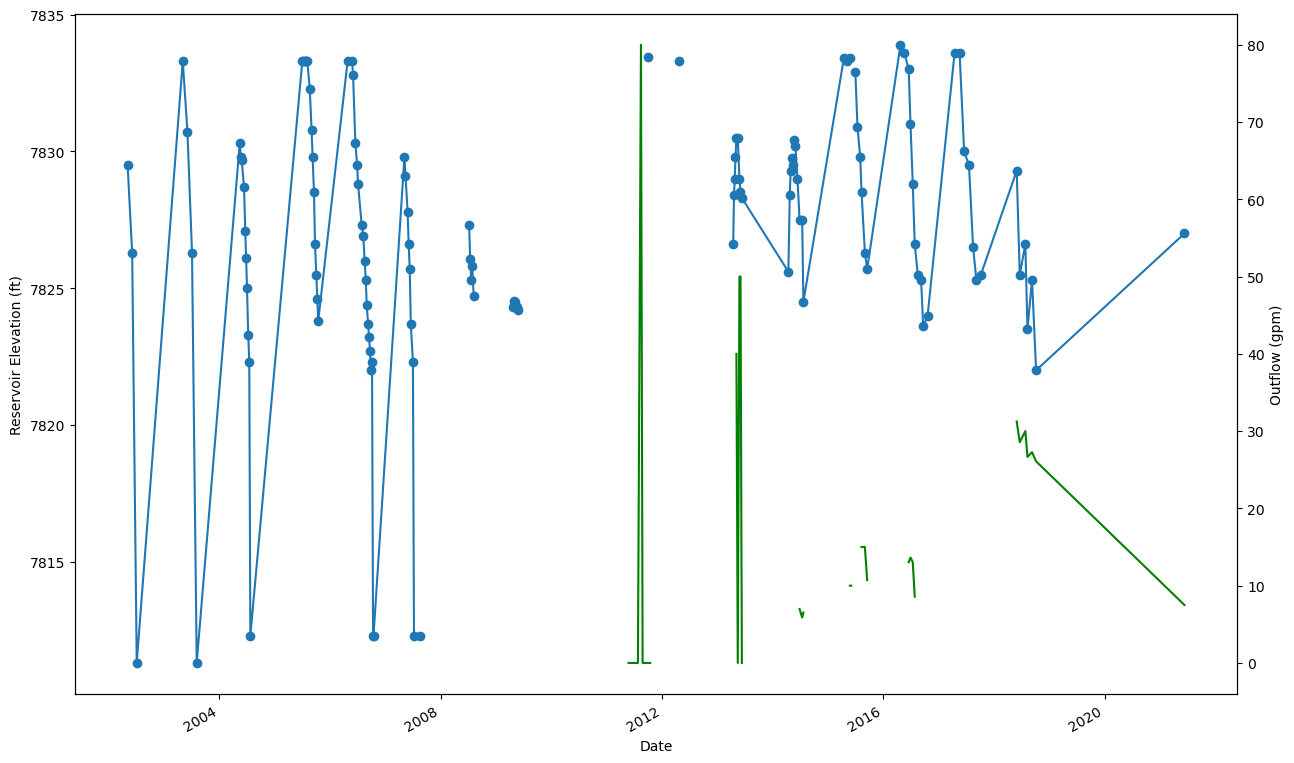

In [155]:
tropic['Reservoir Level'].plot(marker="o")
plt.ylabel('Reservoir Elevation (ft)')
ax2 = plt.twinx()
tropic['2-inch drain gpm'].plot(color='green',ax=ax2)
ax2.set_ylabel('Outflow (gpm)')